03_Entrenamiento_Evaluacion.ipynb

Objetivo: Entrenamiento, evaluación de modelos (5 supervisados + 1 no supervisado) con class_weight='balanced' para maximizar el Recall, usando Pipelines y optimizando los 2 mejores.

In [35]:

#LIBRERÍAS
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from collections import Counter # Para ver la distribución de clases

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans # Modelo no supervisado
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import recall_score, f1_score, roc_auc_score, accuracy_score


# Importanción datos

In [36]:
df = pd.read_csv("../data/processed/online_shoppers_intention_processed.csv")
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Browser,VisitorType,Weekend,target
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0,1,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0,2,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0,1,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0,2,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0,6,0,1,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0,2,0,1,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0,2,0,1,0
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0,2,0,0,0


In [37]:
y = df['target']
X = df.drop(columns=(['target']), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [38]:
# GUARDADO EN CARPETAS TRAIN Y TEST ( ---
X_train.to_csv("../data/train/X_train.csv", index=False)
y_train.to_csv("../data/train/y_train.csv", index=False)
X_test.to_csv("../data/test/X_test.csv", index=False)
y_test.to_csv("../data/test/y_test.csv", index=False)

In [39]:
#DEFINICIÓN DEL PREPROCESAMIENTO0po (PIPELINE)
# Identificamos las columnas a escalar (las logarítmicas + Bounce/ExitRates)
features_to_scale = [col for col in X_train.columns if col.startswith('log_') or col in ['BounceRates', 'ExitRates']]

# Definimos el preprocesador que solo escalará las continuas
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), features_to_scale)
    ],
    remainder='passthrough' # Deja el resto (binarias/ordinales) sin tocar
)

# Función auxiliar para crear un pipeline con el preprocesamiento definido
def build_pipeline(model_instance):
    """Crea un pipeline que incluye preprocesamiento, selección y el modelo."""
    steps = [
        ('preprocessor', preprocessor), # Escala solo las continuas
        ('selector', VarianceThreshold(threshold=0.01)), # Elimina features de baja varianza
        ('classifier', model_instance)
    ]
    return Pipeline(steps=steps)

In [40]:
#ENTRENAMIENTO BASELINE (5 Supervisados + Compensación de Desbalanceo)
# Calculamos el peso de la posición para XGBoost
neg_count = y_train.value_counts()[0]
pos_count = y_train.value_counts()[1]
scale_pos_weight = neg_count / pos_count

# Definición de los modelos con class_weight='balanced'
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "KNeighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "SVM": SVC(probability=True, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, scale_pos_weight=scale_pos_weight, eval_metric='logloss', random_state=42)
    }

In [41]:
print("\n--- Resultados Baseline (Ordenado por Recall) ---")
results = []
pipelines = {} # Para guardar todos los pipelines

for name, model_instance in models.items():
    pipeline = build_pipeline(model_instance)
    pipeline.fit(X_train, y_train) 
    y_pred = pipeline.predict(X_test)
    pipelines[name] = pipeline # Guardamos el pipeline entrenado
    
    # Guardamos cada Pipeline entrenado (para el requisito trained_model_n.pkl)
    with open(f'../models/trained_model_{name.replace(" ", "_")}.pkl', 'wb') as file:
        pickle.dump(pipeline, file)
    
    # Calculamos métricas
    metrics = {
        'Modelo': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }
    results.append(metrics)

# Ordenar por Recall
results_df = pd.DataFrame(results).sort_values(by='Recall', ascending=False)
display(results_df) 


--- Resultados Baseline (Ordenado por Recall) ---


c:\Users\Raque\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Raque\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:20:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Modelo,Accuracy,Recall,F1 Score,AUC
0,Regresión Logística,0.862936,0.712042,0.616780,0.868535
4,SVM,0.690998,0.706806,0.414747,0.767489
5,XGBoost,0.876318,0.680628,0.630303,0.885926
2,Decision Tree,0.847526,0.518325,0.512953,0.712288
3,Random Forest,0.897810,0.510471,0.607477,0.893171
1,KNeighbors,0.851176,0.285340,0.372650,0.752203


Text(0.5, 1.0, 'Comparativa de modelos por métricas')

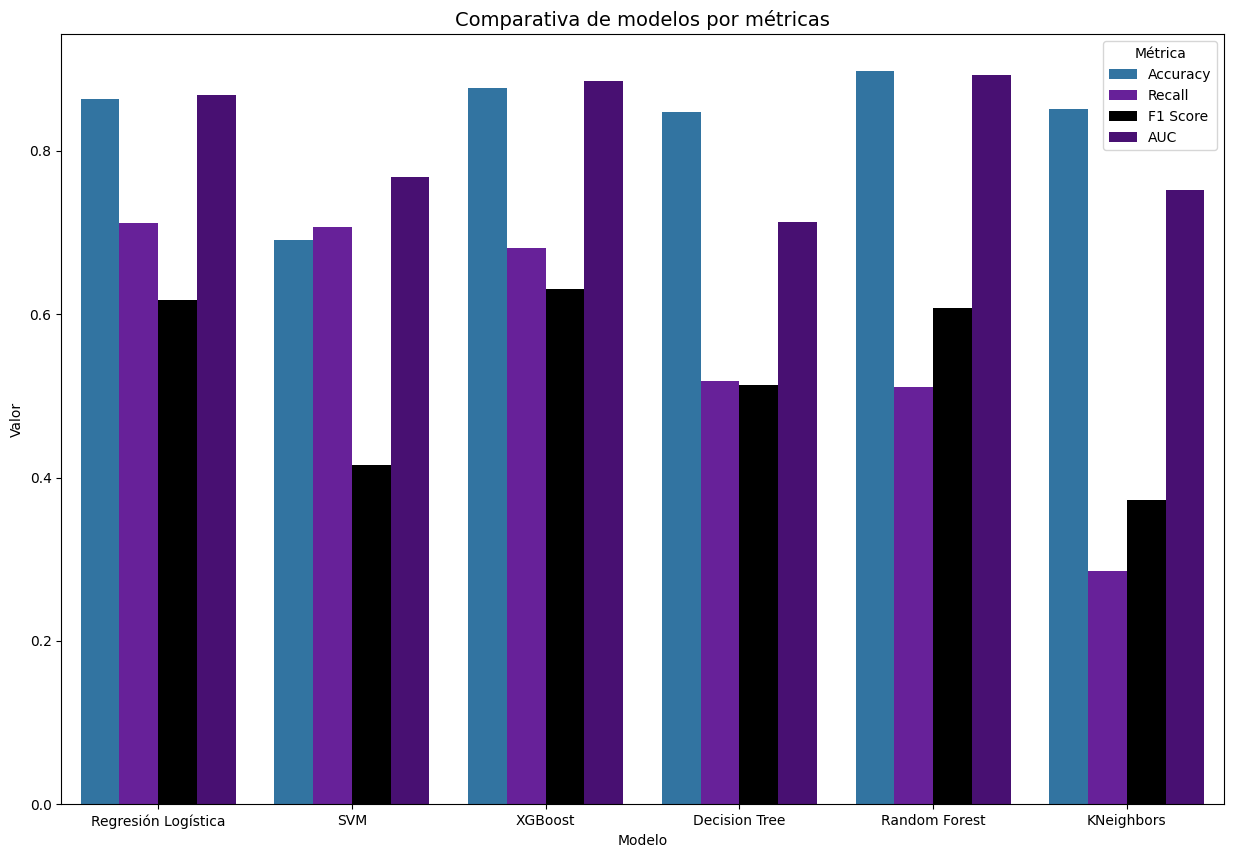

In [58]:

df_melted = results_df.melt(id_vars='Modelo',
                            value_vars=['Accuracy', 'Recall', 'F1 Score', 'AUC'],
                            var_name='Métrica',
                            value_name='Valor')

custom_palette = ['#1f77b4', '#6a0dad', '#000000', '#4b0082']  



plt.figure(figsize=(15, 10))

# Gráfico de barras agrupadas
sns.barplot(data=df_melted, x='Modelo', y='Valor', hue='Métrica', palette=custom_palette)

# Ajustes visuales
plt.title('Comparativa de modelos por métricas', fontsize=14)


C:\Users\Raque\AppData\Local\Temp\ipykernel_29432\1809794888.py:11: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.barplot(data=df_melted, x='Modelo', y='Valor', hue='Métrica', palette=custom_palette)


Text(0.5, 1.0, 'Comparativa de modelos por métricas solo recall')

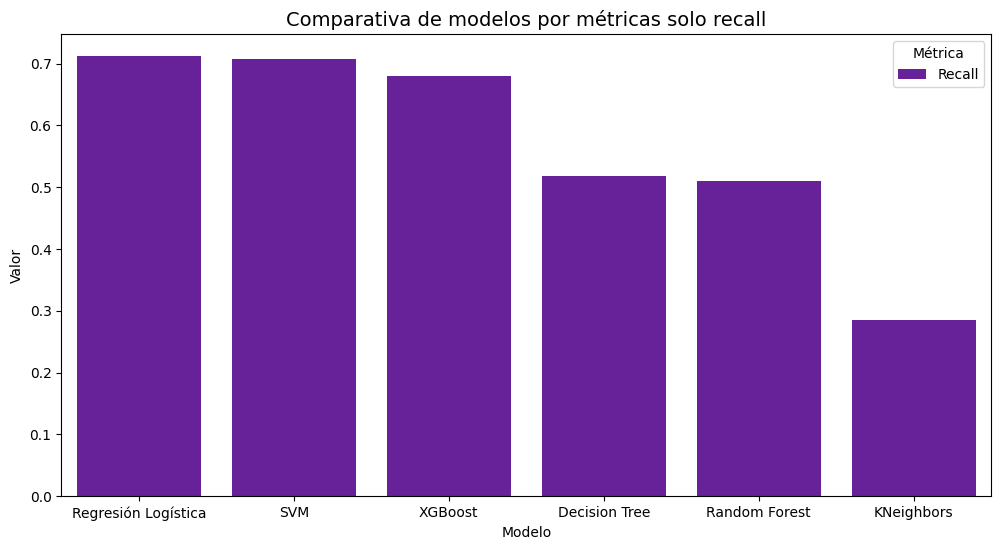

In [43]:
df_melted = results_df.melt(id_vars='Modelo',
                            value_vars=['Recall',],
                            var_name='Métrica',
                            value_name='Valor')


custom_palette = [ '#6a0dad', '#1f77b4', '#000000', '#4b0082']  
plt.figure(figsize=(12, 6))

# Gráfico de barras agrupadas
sns.barplot(data=df_melted, x='Modelo', y='Valor', hue='Métrica', palette=custom_palette)

# Ajustes visuales
plt.title('Comparativa de modelos por métricas solo recall', fontsize=14)

In [44]:
# Seleccionamos los 2 modelos con mejor Recall para la optimización
top_2_models = results_df.head(2)['Modelo'].tolist()
print(f"\n--> Modelos elegidos para optimización (Mejor Recall): {top_2_models}")


--> Modelos elegidos para optimización (Mejor Recall): ['Regresión Logística', 'SVM']


In [45]:

####Optimizando los 2 Modelos con Mejor Recall (Máximo F1 Score con CV=3) ")

# Configuraciones de optimización para los dos modelos (centrado en C para LogReg/SVM, F1 para equilibrio)
optimization_configs = {
    "Regresión Logística": {
        'model': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'param_grid': {'classifier__C': [0.01, 0.1, 1, 10]},
    },
    "SVM": {
        'model': SVC(probability=True, random_state=42, class_weight='balanced'),
        # Grid simplificado para SVM para velocidad (solo C)
        'param_grid': {'classifier__C': [0.1, 1, 10]}, 
    }
}

final_results_optimized = []
best_optimized_models = {} # Para guardar los pipelines optimizados

for name in top_2_models:
    if name not in optimization_configs:
        continue # Ignorar si no es LogReg o SVM (aunque deberían ser los ganadores por Recall)
        
    config = optimization_configs[name]
    pipeline_opt = build_pipeline(config['model'])
    
    #  GridSearch buscando el mejor F1 Score para equilibrio
    grid = GridSearchCV(pipeline_opt, config['param_grid'], scoring='f1', cv=3) 
    grid.fit(X_train, y_train)
    best_model_optimized = grid.best_estimator_
    best_optimized_models[name] = best_model_optimized
    
    # Búsqueda de Umbral Óptimo (Threshold Tuning)
    y_proba = best_model_optimized.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.05)
    
    # Encontramos el umbral que maximiza el F1 Score
    scores = [f1_score(y_test, y_proba >= t) for t in thresholds]
    best_thresh = thresholds[np.argmax(scores)]
    
    # Evaluación final con el umbral óptimo
    y_pred_final = (y_proba >= best_thresh).astype(int)
    
    final_results_optimized.append({
        'Modelo': f"{name} (Optimizado)",
        'Accuracy': accuracy_score(y_test, y_pred_final),
        'Recall': recall_score(y_test, y_pred_final),
        'F1 Score': f1_score(y_test, y_pred_final),
        'AUC': roc_auc_score(y_test, y_proba),
        'Umbral Óptimo': best_thresh
    })

df_optimizacion = pd.DataFrame(final_results_optimized).sort_values(by='F1 Score', ascending=False)
display(df_optimizacion)


c:\Users\Raque\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Raque\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://s

,Modelo,Accuracy,Recall,F1 Score,AUC,Umbral Óptimo
0,Regresión Logística (Optimizado),0.871857,0.678010,0.621103,0.871009,0.55
1,SVM (Optimizado),0.784266,0.782723,0.529204,0.824240,0.10


In [46]:
print("\n--- COMPARACIÓN TOTAL (BASELINE vs. OPTIMIZADO) ---")

# Preparamos los datos para la tabla comparativa
comparative_data = []

# Añadir los resultados BASELINE
for _, row in results_df.iterrows():
    if row['Modelo'] in top_2_models:
        comparative_data.append({
            'Etapa': 'Baseline',
            'Modelo': row['Modelo'],
            'Accuracy': row['Accuracy'],
            'Recall': row['Recall'],
            'F1 Score': row['F1 Score'],
            'AUC': row['AUC'],
            'Umbral': 0.50 # Umbral por defecto
        })

# Añadir los resultados OPTIMIZADOS
for _, row_opt in df_optimizacion.iterrows():
    name = row_opt['Modelo'].replace(' (Optimizado)', '')
    comparative_data.append({
        'Etapa': 'Optimizado',
        'Modelo': name,
        'Accuracy': row_opt['Accuracy'],
        'Recall': row_opt['Recall'],
        'F1 Score': row_opt['F1 Score'],
        'AUC': row_opt['AUC'],
        'Umbral': row_opt['Umbral Óptimo']
    })

df_comparacion_total = pd.DataFrame(comparative_data).sort_values(by='F1 Score', ascending=False)
display(df_comparacion_total)



--- COMPARACIÓN TOTAL (BASELINE vs. OPTIMIZADO) ---


,Etapa,Modelo,Accuracy,Recall,F1 Score,AUC,Umbral
2,Optimizado,Regresión Logística,0.871857,0.678010,0.621103,0.871009,0.55
0,Baseline,Regresión Logística,0.862936,0.712042,0.616780,0.868535,0.50
3,Optimizado,SVM,0.784266,0.782723,0.529204,0.824240,0.10
1,Baseline,SVM,0.690998,0.706806,0.414747,0.767489,0.50


In [47]:
# SELECCIÓN FINAL Y GUARDADO
# Decisión: Seleccionar el modelo con el mejor RECALL de toda la tabla (Baseline o Optimizado)
winner_by_recall = df_comparacion_total.sort_values(by='Recall', ascending=False).iloc[0]
winning_model_name = winner_by_recall['Modelo']
winning_stage = winner_by_recall['Etapa']
final_recall = winner_by_recall['Recall']
final_f1 = winner_by_recall['F1 Score']
BEST_THRESH_FOR_DEPLOYMENT = winner_by_recall['Umbral']


print(f"\n=================================================================")
print(f"🥇 DECISIÓN FINAL (Prioridad: Máximo Recall):")
print(f"   Modelo ganador: {winning_model_name} ({winning_stage})")
print(f"   Recall Final: {final_recall:.4f}")
print(f"   F1 Score Final: {final_f1:.4f}")
print(f"   Umbral de Despliegue: {BEST_THRESH_FOR_DEPLOYMENT:.4f}")
print(f"=================================================================")


🥇 DECISIÓN FINAL (Prioridad: Máximo Recall):
   Modelo ganador: SVM (Optimizado)
   Recall Final: 0.7827
   F1 Score Final: 0.5292
   Umbral de Despliegue: 0.1000


Reg Log: 
- El optimizado mejora ligeramente en Accuracy, F1 Score y AUC.
- Pero empeora el Recall, lo que significa que detecta menos compradores.
- El umbral sube de 0.50 a 0.55, lo que suele hacer que el modelo sea más conservador (menos positivos detectados).
Conclusión: Si tu prioridad es detectar compradores, el baseline es mejor

SVM:
- El optimizado mejora en todo: Accuracy, Recall, F1 y AUC.
- El umbral baja a 0.10, lo que hace que el modelo sea más agresivo (detecta más positivos).
- El Recall sube bastante, lo que indica que detecta más compradores sin perder demasiado en precisión.
🔎Conclusión: Aquí el optimizado es claramente superior,


In [ ]:
#MODELO NO SUPERVISADO (K-Means)
print("\n--- K-Means (Segmentación de Clientes  ---")

# El modelo K-Means también usa el preprocesador del mejor modelo para asegurar que los datos estén escalados
temp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', VarianceThreshold(threshold=0.01))
])

X_data = df.drop(columns=['target'])
# Importante: Aplicar la transformación aprendida en el train
X_data_for_kmeans = temp_pipeline.fit_transform(X_data) 

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_data_for_kmeans) 
print("Clustering realizado en 3 segmentos.")


--- K-Means (Segmentación de Clientes - Requisito) ---
Clustering realizado en 3 segmentos.


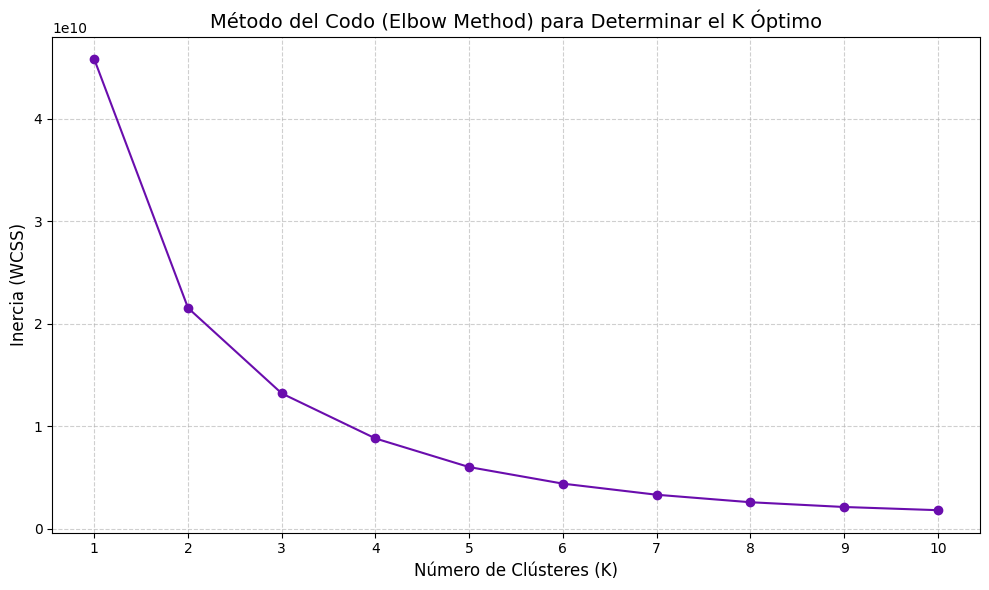

In [56]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# --- REUTILIZACIÓN DE VARIABLES ---
# X_data_for_kmeans es el input del clustering

# 1. Calcular la Inercia (WCSS) para diferentes valores de K
wcss = []
k_range = range(1, 11) # Rango de 1 a 10 clústeres

for k in k_range:
    # Ajustamos K-Means en cada iteración
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_data_for_kmeans) # Usando tu variable
    wcss.append(kmeans_model.inertia_)

# 2. Generar el gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='#6a0dad') 

# Añadir etiquetas y título
plt.title('Método del Codo (Elbow Method) para Determinar el K Óptimo', fontsize=14)
plt.xlabel('Número de Clústeres (K)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [49]:
import pickle

In [51]:
# Guardamos el Pipeline final seleccionado (best_model_shoppers.pkl)
#Clasificador Support Vector Machine (SVM) Optimizado.
with open('../models/best_model_shoppers.pkl', 'wb') as file:
    pickle.dump(best_model_optimized, file)
    
# Guardamos el modelo no supervisado
with open('../models/kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

Text(0.5, 1.0, 'Matriz de Confusión - SVM Optimizado (Umbral: 0.1)')

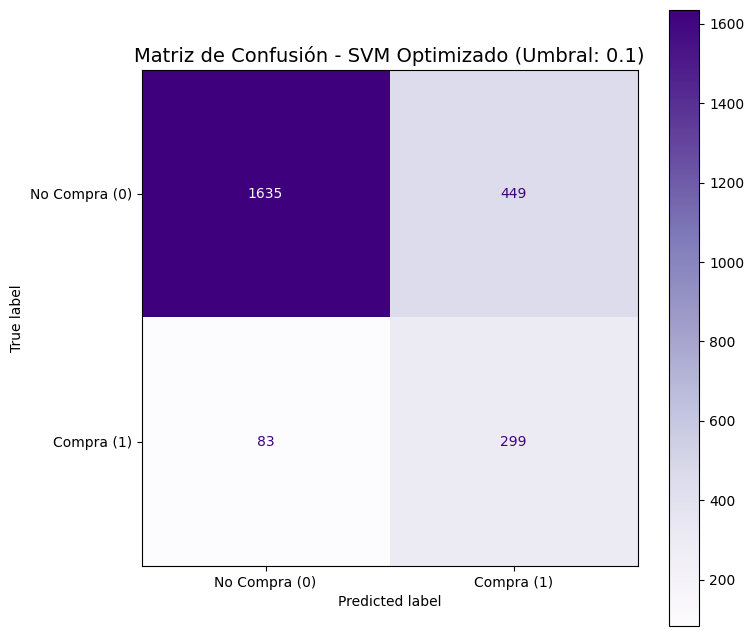

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Variables Clave ---
# Asumimos que estas variables ya están cargadas después de ejecutar tu notebook:
# final_model_to_save (tu Pipeline optimizado de SVM)
# X_test, y_test (tus datos de prueba)
# BEST_THRESH_FOR_DEPLOYMENT (el umbral óptimo)
BEST_THRESH_FOR_DEPLOYMENT = 0.10

# 1. Obtener las probabilidades de predicción para la clase positiva (1)
# El método 'predict_proba' devuelve las probabilidades para ambas clases [0, 1].
# Nos interesa la columna [:, 1] que es la probabilidad de la clase positiva (compra).
y_proba = best_model_optimized.predict_proba(X_test)[:, 1]

# 2. Aplicar el umbral óptimo para obtener las predicciones finales
# Esto es esencial, ya que el método .predict() usaría el umbral por defecto (0.5).
# Con este umbral, capturamos más positivos (mejorando el Recall).
y_pred_final = (y_proba >= BEST_THRESH_FOR_DEPLOYMENT).astype(int)

# 3. Calcular la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_final)

# 4. Visualizar la Matriz de Confusión
# Usamos ConfusionMatrixDisplay para una visualización limpia
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Compra (0)', 'Compra (1)'])




# Configuración del gráfico
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Purples, ax=ax, values_format='d',) # 'd' para formato de entero
plt.title(f'Matriz de Confusión - SVM Optimizado (Umbral: {BEST_THRESH_FOR_DEPLOYMENT})', fontsize=14)





- TN (1635): Casos correctamente clasificados como “No Compra”.
- FP (449): Casos que no compraban, pero el modelo predijo que sí.
- FN (83): Casos que sí compraban, pero el modelo no los detectó.
- TP (299): Casos correctamente clasificados como “Compra”.

📊 Métricas clave derivadas
- Recall = TP / (TP + FN) = 299 / (299 + 83) ≈ 0.7827
→ El modelo detecta 78% de los compradores reales, muy bueno si tu objetivo es no perder ventas.
- Precision = TP / (TP + FP) = 299 / (299 + 449) ≈ 0.40
→ De todos los que el modelo dice que comprarán, solo el 40% realmente lo hacen.
- F1 Score = 2 × (Precision × Recall) / (Precision + Recall) ≈ 0.53
→ Balance entre precisión y recall.

🧠 ¿Cómo influye el umbral 0.1?
- Al bajar el umbral, el modelo se vuelve más agresivo: predice “Compra” más fácilmente.
- Esto aumenta el Recall (menos FN), pero también disminuye la Precision (más FP).
- Es útil si prefieres no perder compradores, aunque eso implique contactar a más personas que no comprarán.



Un umbral de 0.1 es bajo, pero puede ser perfectamente válido si tu objetivo es maximizar el recall (detectar la mayor cantidad posible de compradores). No es lo habitual, pero sí es común en contextos donde los falsos negativos son más costosos que los falsos positivos.
